This tutorial will show you how to use STP to look for an event, check its waveform availability, download and plot waveforms, and access phase picks. 

Make sure you are running Jupyter from the same Python environment where PySTP is or will be installed. To install PySTP from the terminal, clone the Github repo:

    git clone https://github.com/SCEDC/pystp.git

Then run:

    cd pystp
    pip install .

Alternatievely, if you are using Google Colab, or you want to install PySTP from this notebook, uncomment and run the following:

In [1]:
#%pip install git+https://github.com/SCEDC/pystp.git

Once you have installed PySTP, import the ``pystp.STPClient`` module and any other needed modules. ``datetime`` is needed to search for events by date or timestamp.

In [2]:
from pystp import STPClient
import datetime

# Allow plotting in the notebook.
%matplotlib inline

Connect to one of the STP servers by creating a new STPClient object and calling the `connect()` function. By default, it will connect to the first STP server. 

In [3]:
stp = STPClient()
stp.connect()

	****************************************
	*   Welcome to the Southern California *
	*      Earthquake Data Center          *
	*     Seismic Transfer Program         *
        ****************************************

Please use the following citation:
 SCEDC (2013): Southern California Earthquake Data Center.
 Caltech.Dataset. doi:10.7909/C3WD3xH
to cite data downloaded from the SCEDC.

10/13/22: On October 14, 2022, starting at 10am PDT, triggered
data from the last seven days will be inaccessible on stp2, stp3,
and the web services for about 15 minutes.

February 13, 2023:
At 10:30am on February 14, 2023, we will be replacing one of our
web and STP servers. We expect minimal impact for users as they
will continue to reach the old server for a time as as DNS
propagates.




# Finding Events

The `get_events` function searches for events and returns an [ObsPy catalog](https://docs.obspy.org/packages/autogen/obspy.core.event.Catalog.html), which is a container of events.

Let's look for a M4.2 event that occurred on January 25, 2023, near Malibu, CA, by searching for all M4-5 events that occurred between January 25 and January 26.

In [4]:
events = stp.get_events(times=[datetime.datetime(2023, 1, 25), datetime.datetime(2023, 1, 26)], mags=[4, 5])
events

1 Event(s) in Catalog:
2023-01-25T10:00:54.680000Z | +33.885, -118.704 | 4.19 Mw

The events in the catalog can be accessed by index, as in a list. The network ID of the event is set in the field ``Event.resource_id``. The catalog ``events`` only contains one event, so let's store its ID in ``evid.``

In [5]:
evid= events[0].resource_id
evid

40161279

# Listing Available Waveforms

The ``get_eavail`` function runs STP's ``eavail`` command to list available waveforms for an event. Long format, or 'l', will get full listings that include network code, station code, channel code, location code, waveform type, an archival status flag, start time, and duration of the waveform.

``get_eavail`` can return the result as a string or as a Python list, set by the ``as_list`` parameter.

Let's display all the waveforms available forevent 40161279.

In [6]:
print(stp.get_eavail(evid, format='l', as_list=False))

AZ  CRY BHE -- T A 2023/01/25,10:00:44.270      5.37m
AZ  CRY BHN -- T A 2023/01/25,10:00:48.870      5.43m
AZ  CRY BHZ -- T A 2023/01/25,10:00:42.795      5.55m
AZ  CRY HHE -- T A 2023/01/25,10:00:49.138      5.30m
AZ  CRY HHN -- T A 2023/01/25,10:00:50.578      5.31m
AZ  CRY HHZ -- T A 2023/01/25,10:00:49.618      5.27m
AZ  CRY HNE -- T A 2023/01/25,10:00:50.318      5.35m
AZ  CRY HNN -- T A 2023/01/25,10:00:52.608      5.30m
AZ  CRY HNZ -- T A 2023/01/25,10:00:46.638      5.36m
AZ  FRD BHE -- T A 2023/01/25,10:00:47.445      5.41m
AZ  FRD BHN -- T A 2023/01/25,10:00:38.470      5.50m
AZ  FRD BHZ -- T A 2023/01/25,10:00:52.820      5.47m
AZ  FRD HHE -- T A 2023/01/25,10:00:48.958      5.39m
AZ  FRD HHN -- T A 2023/01/25,10:00:52.688      5.25m
AZ  FRD HHZ -- T A 2023/01/25,10:00:53.678      5.23m
AZ  FRD HNE -- T A 2023/01/25,10:00:47.998      5.40m
AZ  FRD HNN -- T A 2023/01/25,10:00:53.688      5.26m
AZ  FRD HNZ -- T A 2023/01/25,10:00:50.778      5.31m
AZ  KNW BHE -- T A 2023/01/2

Narrow down the search by looking at what's available for the station `CI.BAK`. `get_eavail` can search by network, station, or channel. Oracle wildcards ('\_' or '%') are accepted.

In [7]:
stp.get_eavail(evid, format='l', net='CI', sta='BAK', chan="HH_")

[['CI', 'BAK', 'HHE', '--', 'T', 'A', '2023/01/25,10:00:49.318', '5.24m'],
 ['CI', 'BAK', 'HHN', '--', 'T', 'A', '2023/01/25,10:00:48.338', '5.28m'],
 ['CI', 'BAK', 'HHZ', '--', 'T', 'A', '2023/01/25,10:00:50.318', '5.24m']]

Because ``as_list`` was not set, it defaulted to ``True``, and a Python list was returned.

# Downloading Waveforms for an Event

The `get_trig` function downloads waveforms triggered by events and either returns the waveforms as a Python dictionary of ObsPy streams with event IDs as keys. Search parameters of `net` (network), `sta` (station), `chan` (SEED channel), `loc` (location code), and `radius` can be specified to only download data from certain stations or channels that meet the name criteria or are within a radius from the origin. "Blank blank" location codes should be passed in as "--". 

The next command downloads all waveforms from CI.BAKfor the above event and stores them in ``waveforms``.

In [8]:
waveforms = stp.get_trig(evid, net='CI', sta='BAK')
waveforms

Processed 9 waveform traces


{40161279: 9 Trace(s) in Stream:
CI.BAK..BHE | 2023-01-25T10:00:47.169538Z - 2023-01-25T10:06:06.569538Z | 40.0 Hz, 12777 samples
CI.BAK..BHN | 2023-01-25T10:00:49.369538Z - 2023-01-25T10:06:05.394538Z | 40.0 Hz, 12642 samples
CI.BAK..BHZ | 2023-01-25T10:00:45.069538Z - 2023-01-25T10:06:03.969538Z | 40.0 Hz, 12757 samples
CI.BAK..HHE | 2023-01-25T10:00:49.318393Z - 2023-01-25T10:06:03.598393Z | 100.0 Hz, 31429 samples
CI.BAK..HHN | 2023-01-25T10:00:48.338393Z - 2023-01-25T10:06:05.348393Z | 100.0 Hz, 31702 samples
CI.BAK..HHZ | 2023-01-25T10:00:50.318394Z - 2023-01-25T10:06:04.688394Z | 100.0 Hz, 31438 samples
CI.BAK..HNE | 2023-01-25T10:00:46.238393Z - 2023-01-25T10:06:03.268393Z | 100.0 Hz, 31704 samples
CI.BAK..HNN | 2023-01-25T10:00:49.238393Z - 2023-01-25T10:06:03.368393Z | 100.0 Hz, 31414 samples
CI.BAK..HNZ | 2023-01-25T10:00:45.788393Z - 2023-01-25T10:06:07.388393Z | 100.0 Hz, 32161 samples}

`waveforms` is a dictionary that maps the event ID to an ObsPy stream.

[ObsPy stream](https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.html) methods can be used to select traces from the stream and to do processing and plotting. The following line returns a new Stream that only contains data from CI.BAK.HH channels.

In [9]:
waveforms[evid].select(network='CI', station='BAK', channel='HH*')

3 Trace(s) in Stream:
CI.BAK..HHE | 2023-01-25T10:00:49.318393Z - 2023-01-25T10:06:03.598393Z | 100.0 Hz, 31429 samples
CI.BAK..HHN | 2023-01-25T10:00:48.338393Z - 2023-01-25T10:06:05.348393Z | 100.0 Hz, 31702 samples
CI.BAK..HHZ | 2023-01-25T10:00:50.318394Z - 2023-01-25T10:06:04.688394Z | 100.0 Hz, 31438 samples

Let's use ObsPy's 'plot()' function to plot the waveforms from CI.BAK.HH.

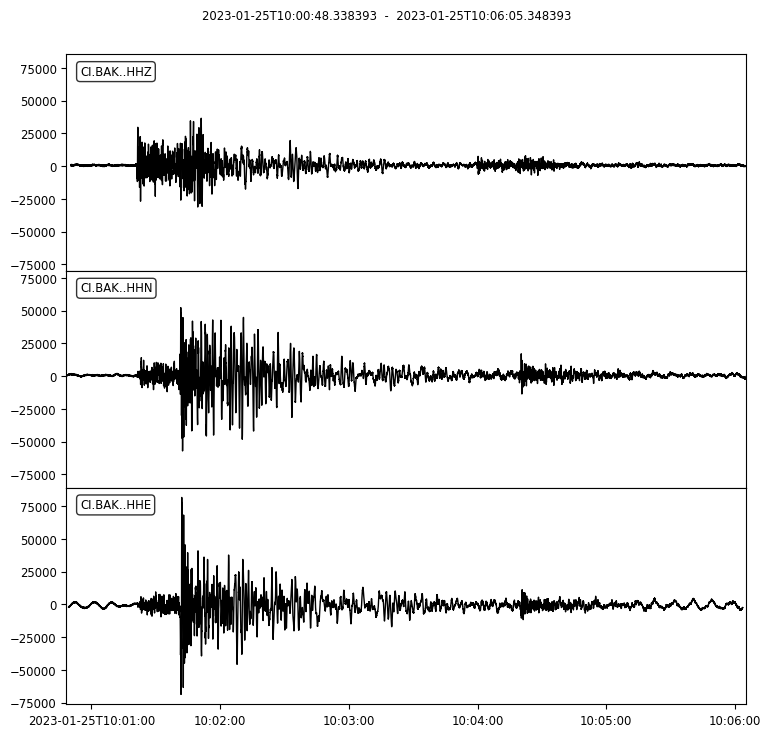

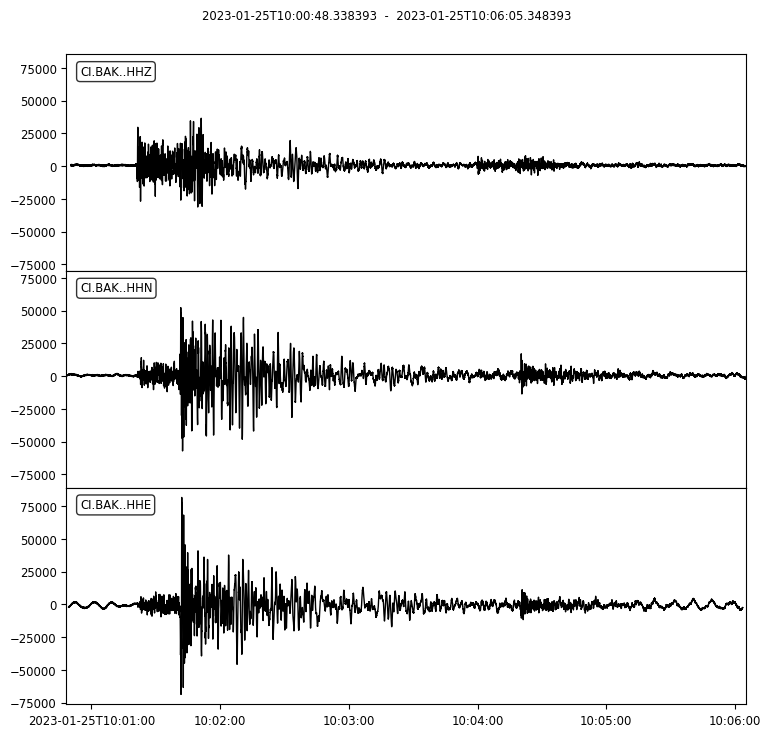

In [10]:
waveforms[evid].select(channel='HH*').plot()

# Downloading Phase Picks



The `get_phases` method to download ObsPy Catalogs with phase picks. `get_phases` can accept one or more event IDs in a list and returns an ObsPy Catalog containing both the event information and the phase picks.

In [11]:
phase_catalog = stp.get_phases(evids=[evid])
phase_catalog

1 Event(s) in Catalog:
2023-01-25T10:00:54.680000Z | +33.885, -118.704 | 4.19 Mw

The Catalog is a list of events that can be access by index.

In [12]:
phase_catalog[0]

Event:	2023-01-25T10:00:54.680000Z | +33.885, -118.704 | 4.19 Mw

	 resource_id: ResourceIdentifier(id="40161279")
	  event_type: 'earthquake'
	        ---------
	       picks: 287 Elements
	     origins: 1 Elements
	  magnitudes: 1 Elements

This event has 287 picks stored in the `picks` list.

In [13]:
phase_catalog[0].picks

[Pick
	 resource_id: ResourceIdentifier(id="smi:local/0376adba-1de7-4462-ad62-094ec8c87b87")
	        time: UTCDateTime(2023, 1, 25, 10, 0, 58, 219000) [upper_uncertainty=0.01]
	 waveform_id: WaveformStreamID(network_code='CI', station_code='PTD', channel_code='HHZ', location_code='--')
	       onset: 'impulsive'
	    polarity: 'positive',
 Pick
	 resource_id: ResourceIdentifier(id="smi:local/a1578292-1972-4e53-880e-008b190e5755")
	        time: UTCDateTime(2023, 1, 25, 10, 1, 0, 953000) [upper_uncertainty=0.02]
	 waveform_id: WaveformStreamID(network_code='CI', station_code='PTD', channel_code='HHN', location_code='--')
	       onset: 'emergent',
 Pick
	 resource_id: ResourceIdentifier(id="smi:local/5a0f099e-0fbe-440c-beb0-6be959bfaa1a")
	        time: UTCDateTime(2023, 1, 25, 10, 0, 58, 369000) [upper_uncertainty=0.02]
	 waveform_id: WaveformStreamID(network_code='CE', station_code='24396', channel_code='HNZ', location_code='--')
	       onset: 'emergent',
 Pick
	 resource_id: Resour

You can also download phase picks and store them in a file.

In [14]:
stp.get_phases(evids=[evid], output_file='phases.txt')

1 Event(s) in Catalog:
2023-01-25T10:00:54.680000Z | +33.885, -118.704 | 4.19 Mw

In [15]:
# Display the first lines of phases.txt
!head phases.txt

  40161279 eq  l 2023/01/25,10:00:54.680   33.8850   -118.7045  14.71  4.19  w 1.0
	CI    PTD HHZ --   34.0044  -118.8069     6.0 P c. i  0.8   16.29   3.539
	CI    PTD HHN --   34.0044  -118.8069     6.0 S .. e  0.5   16.29   6.273
	CE  24396 HNZ --   34.0122  -118.8022    34.0 P .. e  0.5   16.76   3.689
	CE  24396 HNN --   34.0122  -118.8022    34.0 S .. e  0.5   16.76   6.551
	CI    LAT HHZ --   34.0445  -118.7764   351.0 P d. i  0.8   18.92   3.892
	CI    LAT HHN --   34.0445  -118.7764   351.0 S .. i  0.8   18.92   7.010
	NP   5081 EHZ --   34.0838  -118.5990   203.0 P d. i  0.8   24.13   4.554
	NP   5081 HNN --   34.0838  -118.5990   203.0 S .. e  0.5   24.13   7.960
	CE  24014 HNZ --   34.0449  -118.5223    95.0 P d. i  0.8   24.46   4.949


# Disconnecting from the STP Server

When you are done, disconnect from the server. After disconnecting, you will need to run `connect()` again to use the STP server.

In [16]:
stp.disconnect()

# More Tutorials

See PySTP [Example Notebook 1](https://github.com/SCEDC/pystp/blob/master/Example%20Notebook.ipynb) and [Example Notebook 2](https://github.com/SCEDC/pystp/blob/master/Example%20Notebook%202%20-%20Events%20and%20Phases.ipynb) for more examples and documentation